![logo](../LogoLine_horizon_C3S.png)

# Deriving ENSO indices used in C3S graphical products from CDS data

This example shows how to compute the El Niño–Southern Oscillation (ENSO) indices used in [C3S seasonal graphical products](https://climate.copernicus.eu/charts/packages/c3s_seasonal/), from ERA5 SST data retrieved from the CDS. This is also shown for one seasonal real-time forecast system, computing the ENSO indices over the hindcast period.

In a complementary Notebook, the indices prepared here will be used to compute the correlation heatmaps displayed for the SST indices on the [verification page](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecasts+verification+plots). 

Some information on ENSO impacts in Europe can be found on [a page in the C3S documentation](https://confluence.ecmwf.int/display/COPSRV/ENSO+impacts+on+Europe).

1. [Configuration](#configuration)
2. [Define ENSO regions](define-enso-regions)
3. [ERA5 CDS API request](#era5-cds-api-request)
4. [Compute ERA5 indices and save](#compute-era5-indices-and-save) 
5. [Hindcast CDS API request](#hindcast-cds-api-request)
6. [Compute hindcast indices and save](#compute-hindcast-indices-and-save) 


:::{note}
Some of the python code uses a set of [utility functions](https://github.com/ecmwf-projects/c3s-seasonal-forecasts/tree/main/utils) available in the GitHub respository which hosts these Notebooks.
:::

## Configuration

Import required modules and configure the CDS API client. Define a dictionary of C3S seasonal real-time forecast systems and versions to use.

**Note that the URL and KEY need to be filled in with the details from your CDS account, and the [cdsapi package](https://cds.climate.copernicus.eu/how-to-api) needs to be installed.** Ideally, a `.cdsapirc` file should be created, to avoid the possibility of exposing credentials when sharing Notebooks. CDS API requests can now also be made using earthkit, as shown in [this example](https://earthkit-data.readthedocs.io/en/latest/examples/cds.html).

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import regionmask
import cdsapi
import os
import sys
from pathlib import Path

# Add parent directory to path so we can import the utils package
sys.path.insert(0, str(Path.cwd().parent))
from utils.tools import getForecastsystemDetails


URL = 'https://cds.climate.copernicus.eu/api'
KEY = '' # INSERT CDS KEY HERE IF NEEDED
c = cdsapi.Client(url=URL, key=KEY) # if a .cdsapirc file is used, url and key can be omitted

## Define ENSO regions

Define some characteristics of the SST indices to calculate for this example. Then create a `regionmask` object based on them. For further details see the [regionmask package documentation](https://regionmask.readthedocs.io/en/stable/).

In [2]:
nino_bboxes = list()
nino_bboxes.append(np.array([[270, -10], [270, 0], [280, 0], [280, -10]]))  # NINO12
nino_bboxes.append(np.array([[210, -5], [210, 5], [270, 5], [270, -5]]))  # NINO3
nino_bboxes.append(np.array([[190, -5], [190, 5], [240, 5], [240, -5]]))  # NINO34
nino_bboxes.append(np.array([[160, -5], [160, 5], [210, 5], [210, -5]]))  # NINO4

names = ["NINO1+2", "NINO3", "NINO3.4", "NINO4"]
abbrevs = [n.split("NINO")[1] for n in names]

ind_defs = regionmask.Regions(nino_bboxes, names=names, abbrevs=abbrevs, name="NINO")

Plot an example region to check everything is working as expected.

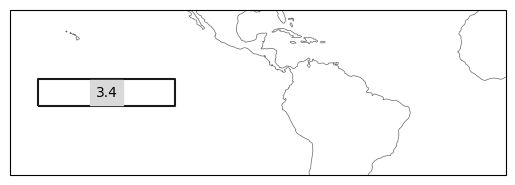

In [3]:
ax = ind_defs[["NINO3.4"]].plot(label='abbrev')
ax.set_extent([-180, 0, -30, 30], crs=ccrs.PlateCarree())

Note that the region mask package assigns a number to each region, which is the integer used in the mask.

## ERA5 CDS API request

Define the directory where the data will be saved. Set request details to be used by the API requests, and perform the API request.

The CDS API keywords used are:

**Product type**: `monthly_averaged_reanalysis`<br>
**Variable**: `sea_surface_temperature` <br>
**Year**: `1993 to 2016` *the common hindcast period* <br>
**Month**: `01 to 12` *all months* <br>
**Time**: `00:00` *the only option for monthly means* <br>
**Format**: `grib` <br>
**Download format**: `unarchived` *returned file is not zipped*<br>

In [3]:
data_path = 'data'

In [ ]:
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": ["sea_surface_temperature"],
    "year": [
        "1993", "1994", "1995",
        "1996", "1997", "1998",
        "1999", "2000", "2001",
        "2002", "2003", "2004",
        "2005", "2006", "2007",
        "2008", "2009", "2010",
        "2011", "2012", "2013",
        "2014", "2015", "2016"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "grib",
    "download_format": "unarchived"
}

c.retrieve(dataset, request, data_path + '/era5_monthly_sst_hc_period.grib')

## Compute ERA5 indices and save

Load the data into xarray. Then define a mask using the `mask_3D_frac_approx` function, which deals with fractional overlap between the defined regions and grid cells (indicating how much of the grid cell is covered by the region). This helps to create more exact regional means.

Then, apply the mask and compute the cell-weighted area average.

In [6]:
# read in data
sst_data = xr.open_dataarray(data_path + '/era5_monthly_sst_hc_period.grib', engine='cfgrib')
sst_data = sst_data.rename({'longitude': 'lon','latitude': 'lat'})

# apply the mask and compute area average
sst_data_mask = ind_defs.mask_3D_frac_approx(sst_data)
weights = np.cos(np.deg2rad(sst_data.lat))
sst_inds = sst_data.weighted(sst_data_mask * weights).mean(dim=("lat", "lon"))

Inspect the data objects that were just used and produced.

In [7]:
sst_data

<xarray.DataArray 'sst' (time: 288, lat: 721, lon: 1440)> Size: 1GB
array([[[271.45972, 271.45972, ..., 271.45972, 271.45972],
        [271.45972, 271.45972, ..., 271.45972, 271.45972],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[271.45972, 271.45972, ..., 271.45972, 271.45972],
        [271.45972, 271.45972, ..., 271.45972, 271.45972],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[271.46045, 271.46045, ..., 271.46045, 271.46045],
        [271.46045, 271.46045, ..., 271.46045, 271.46045],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[271.46045, 271.46045, ..., 271.46045, 271.46045],
        [271.46045, 271.46045, ..., 271.46045, 271.46045],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]]],
      shape=(288, 721, 1440), dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2kB 1993-01-01 1993-02-01 ... 2016-12-01
  * lat         (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon         (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    number      int64 8B 0
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
    valid_time  (time) datetime64[ns] 2kB ...
Attributes: (12/30)
    GRIB_paramId:                             34
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_name:                                Sea surface temperature
    GRIB_shortName:                           sst
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

In [8]:
sst_inds

<xarray.DataArray 'sst' (time: 288, region: 4)> Size: 9kB
array([[297.40361302, 298.71589459, 299.96271057, 301.79814443],
       [299.43700675, 299.51221943, 300.0285691 , 301.45587454],
       [300.28422079, 300.61804533, 300.77114741, 301.62494208],
       ...,
       [294.24928403, 297.79543546, 299.31767409, 301.46601963],
       [294.64010894, 297.69924189, 299.36025281, 301.37185368],
       [295.90601987, 297.84555784, 299.31758122, 301.42310519]],
      shape=(288, 4))
Coordinates:
  * time        (time) datetime64[ns] 2kB 1993-01-01 1993-02-01 ... 2016-12-01
  * region      (region) int64 32B 0 1 2 3
    number      int64 8B 0
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
    valid_time  (time) datetime64[ns] 2kB 1993-01-01 1993-02-01 ... 2016-12-01
    abbrevs     (region) <U3 48B '1+2' '3' '3.4' '4'
    names       (region) <U7 112B 'NINO1+2' 'NINO3' 'NINO3.4' 'NINO4'

Now save the indices.

In [9]:
file_name = '/era_5_nino_ind_1993_2016.nc'
if os.path.exists(data_path + file_name):
    os.remove(data_path + file_name)

sst_inds.to_netcdf(data_path + file_name, mode='w')

## Hindcast CDS API request

Set request details to be used by the API requests, and perform the API request.

In [ ]:
origin = 'ukmo'  # originating centre label for the CDS request
system = '604'  # forecast system identifier for the CDS request
prov = f'{origin}.s{system}'

# Get system details from configuration files in utils directory using format ukmo.s604
system_details = getForecastsystemDetails(prov)
lagged = system_details.get('system_details',{}).get('isLagged',False)
print(system_details)

{'origin_details': {'MARS_origin': 'egrr', 'label': 'Met Office'}, 'system_details': {'name': 'GloSea6 (system=604)', 'isLagged': True, 'ens_size': {'products': {'fc': 50}}}}


The CDS API keywords used are:

**Format**: `Grib` <br>
**Originating centre**: `UKMO`<br>
**Variable**: `sea_surface_temperature` <br>
**System**: `604`<br>
**Product type**: `monthly_mean`<br>
**Year**: `1993 to 2016` *the common hindcast period* <br>
**Month**: `01 to 12` *all start months selected one by one* <br>
**Leadtime month**: `1 to 6` *all lead months available* <br>

The for loop is used to request and save each start month one by one.

In [5]:
start_mons = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
hc_period = ['1993', '2016']
hc_str = '_'.join([hc_period[0], hc_period[1]])

In [ ]:
# loop over the starts to download
for st_mon in start_mons:
    dataset = "seasonal-monthly-single-levels"
    request = {
        "originating_centre": origin,
        "system": system,
        "variable": ["sea_surface_temperature"],
        "product_type": ["monthly_mean"],
        "year": [
            "1993", "1994", "1995",
            "1996", "1997", "1998",
            "1999", "2000", "2001",
            "2002", "2003", "2004",
            "2005", "2006", "2007",
            "2008", "2009", "2010",
            "2011", "2012", "2013",
            "2014", "2015", "2016"
        ],
        "month": st_mon,
        "leadtime_month": [
            "01", "02", "03",
            "04", "05", "06"],
        "data_format": "grib"
    }

    fn = data_path + f'/sst_mm_{origin}_{system}_{hc_str}_st_{st_mon}.grib'
    print(fn)
    c.retrieve(dataset, request, fn)

## Compute hindcast indices and save

First, prepare for the lagged start time coordinates, where careful treatment is required when loading the data into xarray. Some of the seasonal forecast monthly data on the CDS comes from systems using members initialized on different start dates (lagged start date ensembles). In the GRIB encoding used for those systems we will therefore have two different xarray/cfgrib keywords for the real start date of each member (`time`) and for the nominal start date (`indexing_time`) which is the one we would need to use for those systems initializing their members with a lagged start date approach. 

In [6]:
# For the re-shaping of time coordinates in xarray.Dataset we need to select the right one 
#  -> burst mode ensembles (e.g. ECMWF SEAS5) use "time". 
#  -> lagged start ensembles (e.g. Met Office GloSea6) use "indexing_time" (see documentation about nominal start date)
if lagged:
    st_dim_name = 'indexing_time'
else:
    st_dim_name = 'time' 

Loop over each start month, read the data, then as before, define a mask using the `mask_3D_frac_approx` function. Apply the mask and compute the cell-weighted area average, and save the data.

In [ ]:
# loop over the starts to read data and compute indices
for st_mon in start_mons:
    fnheader = f'sst_mm_{origin}_{system}_{hc_str}_st_{st_mon}'
    # read in data
    fn = data_path + f'/{fnheader}.grib'
    sst_data = xr.open_dataarray(fn, engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', st_dim_name)))
    sst_data = sst_data.rename({'longitude': 'lon','latitude': 'lat', st_dim_name:'start_date'})
    # sst_data = sst_data.reindex(lat=sst_data.lat[::-1])

    ind_defs = regionmask.Regions(nino_bboxes, names=names, abbrevs=abbrevs, name="NINO")

    sst_data_mask = ind_defs.mask_3D_frac_approx(sst_data)
    weights = np.cos(np.deg2rad(sst_data.lat))
    sst_inds = sst_data.weighted(sst_data_mask * weights).mean(dim=("lat", "lon"))

    # save the indices
    file_name = f'/{fnheader}_nino_ind.nc'
    if os.path.exists(data_path + file_name):
        os.remove(data_path + file_name)
    print('saving sst_inds for start: ', st_mon)
    sst_inds.to_netcdf(data_path + file_name, mode='w')

The NINO index data saved for both ERA5 and the hindcasts from the example system are used in a follow-up Notebook to compute the temporal correlation between the hindcast mean and ERA5, and then construct correlation heatmaps (as shown on the [verification page](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecasts+verification+plots) in the documentation).